---
title: "Beer Markets | Hw 3 Post"
author: "Daniel Noone"
date: '2025-04-04'
categories: ['Homework', 'PySpark', 'Linear Regression']
image: beer.jpg
execute:
  warning: false
  message: false
toc: true
output:
  html_document:
    keep_md: true
---


# Importing Modules and Data

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, when, log
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression



In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

beer_markets = pd.read_csv(
  'https://bcdanl.github.io/data/beer_markets_all_cleaned.csv'
)
bm = spark.createDataFrame(beer_markets)
bm.show()

+---------+--------------------+--------+---------+------------+---------+------------------+--------------------+-----+-------+----------+----------------+---------+--------+--------------+-------------+---+----------+-------+--------------------+------+---------+----------+-------+----------------+-------+
|household|     X_purchase_desc|quantity|    brand|dollar_spent|beer_floz|        price_floz|           container|promo| region|     state|          market|buyertype|  income|childrenUnder6|children6to17|age|employment| degree|          occupation|ethnic|microwave|dishwasher|tvcable|singlefamilyhome|npeople|
+---------+--------------------+--------+---------+------------+---------+------------------+--------------------+-----+-------+----------+----------------+---------+--------+--------------+-------------+---+----------+-------+--------------------+------+---------+----------+-------+----------------+-------+
|  2000946|    BUD LT BR CN 12P|       1|BUD_LIGHT|        8.14|    14

# Q1

In [ ]:
bm = (
    bm
    .filter((col("container") == 'CAN') | (col('container') == 'NON_REFILLABLE_BOTTLE'))
)

bm.groupBy('container').count().show()

+--------------------+-----+
|           container|count|
+--------------------+-----+
|NON_REFILLABLE_BO...|19095|
|                 CAN|53015|
+--------------------+-----+



# Q2

In [ ]:
dtrain, dtest = bm.randomSplit([0.67, 0.33], seed = 123)

In [ ]:
dtrain.describe().show()

+-------+--------------------+--------------------+------------------+-------------+------------------+-----------------+--------------------+--------------------+-------+-------+-------------+---------+--------+-----+----------+-------+--------------------+------+-------+------------------+
|summary|           household|     X_purchase_desc|          quantity|        brand|      dollar_spent|        beer_floz|          price_floz|           container| region|  state|       market|buyertype|  income|  age|employment| degree|          occupation|ethnic|tvcable|           npeople|
+-------+--------------------+--------------------+------------------+-------------+------------------+-----------------+--------------------+--------------------+-------+-------+-------------+---------+--------+-----+----------+-------+--------------------+------+-------+------------------+
|  count|               48375|               48375|             48375|        48375|             48375|            48375|

In [ ]:
dtest.describe().show()

+-------+-------------------+--------------------+------------------+-------------+------------------+------------------+--------------------+--------------------+-------+-------+-------------+---------+--------+-----+----------+-------+--------------------+------+-------+------------------+
|summary|          household|     X_purchase_desc|          quantity|        brand|      dollar_spent|         beer_floz|          price_floz|           container| region|  state|       market|buyertype|  income|  age|employment| degree|          occupation|ethnic|tvcable|           npeople|
+-------+-------------------+--------------------+------------------+-------------+------------------+------------------+--------------------+--------------------+-------+-------+-------------+---------+--------+-----+----------+-------+--------------------+------+-------+------------------+
|  count|              23735|               23735|             23735|        23735|             23735|             23735|

# Q3 - 8

## Q3

* ***Model 1***
  * Uses as features: market, brand, container, and log(beer_floz)

  * market, brand, and container are one-hot encoded with `BUFFALO-ROCHESTER`, `BUD_LIGHT`, and `NON_REFILLABLE_BOTTLE` as respective reference levels


* ***Model 2***
  * Uses the same features as model 1, but with interaction terms between `brand` and `log(beer_floz)`

* ***Model 3***
  * Same features as model 2, but with interaction terms between `brand` and `promo`, `promo` and `log(beer_floz)`,and a tertiary interaction term between `brand`, `promo`, and `log(beer_floz)`

## Q4

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


import numpy as np
import scipy.stats as stats
from tabulate import tabulate

def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)



### Model 1

- market (dummys), brand (dummys), container (CAN not as ref lev), log(beer_floz)

In [ ]:
dtrain = dtrain.withColumn('log_floz', log('beer_floz'))
dtrain = dtrain.withColumn('log_price_floz', log('price_floz'))

dtest = dtest.withColumn('log_floz', log('beer_floz'))
dtest = dtest.withColumn('log_price_floz', log('price_floz'))

dtest.orderBy('market', 'brand')
dtrain.orderBy('market', 'brand')

DataFrame[household: bigint, X_purchase_desc: string, quantity: bigint, brand: string, dollar_spent: double, beer_floz: double, price_floz: double, container: string, promo: boolean, region: string, state: string, market: string, buyertype: string, income: string, childrenUnder6: boolean, children6to17: boolean, age: string, employment: string, degree: string, occupation: string, ethnic: string, microwave: boolean, dishwasher: boolean, tvcable: string, singlefamilyhome: boolean, npeople: string, log_floz: double, log_price_floz: double, market_ALBANY: int, market_ATLANTA: int, market_BALTIMORE: int, market_BIRMINGHAM: int, market_BOSTON: int, market_BUFFALO-ROCHESTER: int, market_CHARLOTTE: int, market_CHICAGO: int, market_CINCINNATI: int, market_CLEVELAND: int, market_COLUMBUS: int, market_DALLAS: int, market_DENVER: int, market_DES_MOINES: int, market_DETROIT: int, market_EXURBAN_NJ: int, market_EXURBAN_NY: int, market_GRAND_RAPIDS: int, market_HARTFORD-NEW_HAVEN: int, market_HOUSTON

In [ ]:
market_dummys, market_reflev = add_dummy_variables('market', reference_level=5)
brand_dummys, brand_reflev = add_dummy_variables('brand', reference_level=0)
container_dummys, container_reflev = add_dummy_variables('container', reference_level=1)
cont = ['log_floz']
features_1 = market_dummys + brand_dummys + container_dummys + cont

Reference category (dummy omitted): BUFFALO-ROCHESTER
Reference category (dummy omitted): BUD_LIGHT
Reference category (dummy omitted): NON_REFILLABLE_BOTTLE


In [ ]:
assembler1 = VectorAssembler(
    inputCols = features_1,
    outputCol='features')

dtrain1 = assembler1.transform(dtrain)
dtest1  = assembler1.transform(dtest)

model1 = LinearRegression(
    featuresCol='features',
    labelCol='log_price_floz'
).fit(dtrain1)

dtest1 = model1.transform(dtest1)

print(regression_table(model1, assembler1))

+-----------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                            |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-----------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: market_ALBANY               |  0.031 |  **  |      0.010 |   0.013 |        0.011 |        0.051 |
| Beta: market_ATLANTA              |  0.095 | ***  |      0.014 |   0.000 |        0.068 |        0.122 |
| Beta: market_BALTIMORE            |  0.099 | ***  |      0.010 |   0.000 |        0.079 |        0.119 |
| Beta: market_BIRMINGHAM           |  0.128 | ***  |      0.011 |   0.000 |        0.107 |        0.149 |
| Beta: market_BOSTON               |  0.129 | ***  |      0.010 |   0.000 |        0.109 |        0.149 |
| Beta: market_CHARLOTTE            |  0.033 | ***  |      0.010 |   0.001 |        0.014 |        0.052 |
| Beta: market_CHICAGO              |

### Model 2

In [ ]:
dtrain, dtest = bm.randomSplit([0.67, 0.33], seed = 123)

In [ ]:
dtrain = dtrain.withColumn('log_floz', log('beer_floz'))
dtrain = dtrain.withColumn('log_price_floz', log('price_floz'))

dtest = dtest.withColumn('log_floz', log('beer_floz'))
dtest = dtest.withColumn('log_price_floz', log('price_floz'))

dtrain.orderBy('market', 'brand')
dtest.orderBy('market', 'brand')

market_dummys, market_reflev = add_dummy_variables('market', reference_level=5)
brand_dummys, brand_reflev = add_dummy_variables('brand', reference_level=0)
container_dummys, container_reflev = add_dummy_variables('container', reference_level=1)
cont = ['log_floz']
features_2 = market_dummys + brand_dummys + container_dummys + cont

Reference category (dummy omitted): BUFFALO-ROCHESTER
Reference category (dummy omitted): BUD_LIGHT
Reference category (dummy omitted): NON_REFILLABLE_BOTTLE


In [ ]:
for i in brand_dummys:
  dtrain = dtrain.withColumn(f"{i}_log_floz", col(i) * col('log_floz'))
  dtest = dtest.withColumn(f"{i}_log_floz", col(i) * col('log_floz'))
  features_2.append(f"{i}_log_floz")

In [ ]:
assembler2 = VectorAssembler(
    inputCols = features_2,
    outputCol='features')

dtrain2 = assembler2.transform(dtrain)
dtest2  = assembler2.transform(dtest)

model2 = LinearRegression(
    featuresCol='features',
    labelCol='log_price_floz'
).fit(dtrain2)

dtest2 = model2.transform(dtest2)

print(regression_table(model2, assembler2))

+------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                             |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: market_ALBANY                |  0.033 | ***  |      0.010 |   0.008 |        0.013 |        0.053 |
| Beta: market_ATLANTA               |  0.094 | ***  |      0.014 |   0.000 |        0.067 |        0.120 |
| Beta: market_BALTIMORE             |  0.101 | ***  |      0.010 |   0.000 |        0.081 |        0.122 |
| Beta: market_BIRMINGHAM            |  0.134 | ***  |      0.011 |   0.000 |        0.113 |        0.155 |
| Beta: market_BOSTON                |  0.128 | ***  |      0.010 |   0.000 |        0.108 |        0.148 |
| Beta: market_CHARLOTTE             |  0.029 | ***  |      0.010 |   0.005 |        0.010 |        0.048 |
| Beta: market_CHICAGO      

### Model 3

In [ ]:
dtrain, dtest = bm.randomSplit([0.67, 0.33], seed = 123)

In [ ]:
dtrain = dtrain.withColumn('log_floz', log('beer_floz'))
dtrain = dtrain.withColumn('log_price_floz', log('price_floz'))

dtest = dtest.withColumn('log_floz', log('beer_floz'))
dtest = dtest.withColumn('log_price_floz', log('price_floz'))

dtrain.orderBy('market', 'brand')
dtest.orderBy('market', 'brand')

market_dummys, market_reflev = add_dummy_variables('market', reference_level=5)
brand_dummys, brand_reflev = add_dummy_variables('brand', reference_level=0)
container_dummys, container_reflev = add_dummy_variables('container', reference_level=1)
cont = ['log_floz']
features_3 = market_dummys + brand_dummys + container_dummys + cont

Reference category (dummy omitted): BUFFALO-ROCHESTER
Reference category (dummy omitted): BUD_LIGHT
Reference category (dummy omitted): NON_REFILLABLE_BOTTLE


In [ ]:
dtrain = dtrain.withColumn('promo_x_log_floz', col('promo').cast('int') * col('log_floz'))
dtest = dtest.withColumn('promo_x_log_floz', col('promo').cast('int') * col('log_floz'))
features_3.append('promo_x_log_floz')

for i in brand_dummys:
  dtrain = dtrain.withColumn(f"{i}_log_floz", col(i) * col('log_floz'))
  dtest = dtest.withColumn(f"{i}_log_floz", col(i) * col('log_floz'))

  dtrain = dtrain.withColumn(f"{i}_promo", col(i) * col('promo').cast('int'))
  dtest = dtest.withColumn(f"{i}_promo", col(i) * col('promo').cast('int'))

  dtrain = dtrain.withColumn(f"{i}_promo_log_floz", col(i) * col('promo').cast('int') * col('log_floz'))
  dtest = dtest.withColumn(f"{i}_promo_log_floz", col(i) * col('promo').cast('int') * col('log_floz'))

  features_3.append(f"{i}_log_floz")
  features_3.append(f"{i}_promo")
  features_3.append(f"{i}_promo_log_floz")

In [ ]:
assembler3 = VectorAssembler(
    inputCols = features_3,
    outputCol='features')

dtrain3 = assembler3.transform(dtrain)
dtest3  = assembler3.transform(dtest)

model3 = LinearRegression(
    featuresCol='features',
    labelCol='log_price_floz'
).fit(dtrain3)

dtest3 = model3.transform(dtest3)

print(regression_table(model3, assembler3))

+------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                                   |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: market_ALBANY                      |  0.027 |  **  |      0.010 |   0.029 |        0.007 |        0.047 |
| Beta: market_ATLANTA                     |  0.090 | ***  |      0.014 |   0.000 |        0.063 |        0.117 |
| Beta: market_BALTIMORE                   |  0.092 | ***  |      0.010 |   0.000 |        0.072 |        0.112 |
| Beta: market_BIRMINGHAM                  |  0.130 | ***  |      0.011 |   0.000 |        0.109 |        0.151 |
| Beta: market_BOSTON                      |  0.126 | ***  |      0.010 |   0.000 |        0.106 |        0.146 |
| Beta: market_CHARLOTTE                   |  0.038 | ***  |      0.010 |   0.000 |     

## Q5

> `market_ALBANY`: 0.027
 - Being in the Albany mkt leads to a 2.7% increase in log(price per fl oz)

> `market_EXURBAN_NY`: 0.128
  - EXURBAN market leads to a larger 12.8% increase in log(price per fl oz)

> `market_RURAL_NEW_YORK`: -0.020
  - Rural NY actually leads to a 2% decrease in log(price per fl oz)

> `market_SUBURBAN_NY`: 0.104
  - Suburban NY leads to a 10.4% increase

> `market_SYRACUSE`: -0.046
  - Syracuse leads to a 4.6% decrease

> `market_URBAN_NY`: 0.170
  - Urban NY leads to a 17% increase

## Q6

>Betas Associated with log(beer_floz)
 - `model 1`: -0.142
 - `model 2`: -0.148
 - `model 3`: -0.143

 - Betas are actually quite similar across the models, with an average of ~ -0.144

 > How did promo affect this in model 3?
- beta associated with the interaction:
  - `-0.008`
- this interaction led to a decreased sensitivity

## Q7

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Model 1

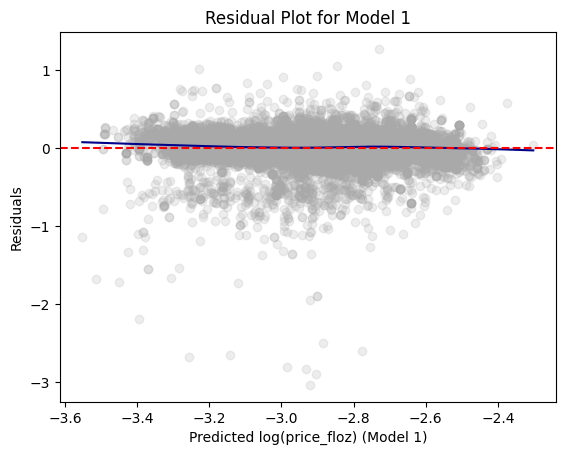

In [ ]:
res_1 = dtest1.select(["prediction", "log_price_floz"]).toPandas()
res_1['residual'] = res_1['log_price_floz'] - res_1['prediction']



plt.scatter(res_1["prediction"], res_1["residual"], alpha=0.2, color="darkgray")

smoothed = sm.nonparametric.lowess(res_1["residual"], res_1["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

plt.axhline(y=0, color="red", linestyle="--")

plt.xlabel("Predicted log(price_floz) (Model 1)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model 1")
plt.show()


### Model 2

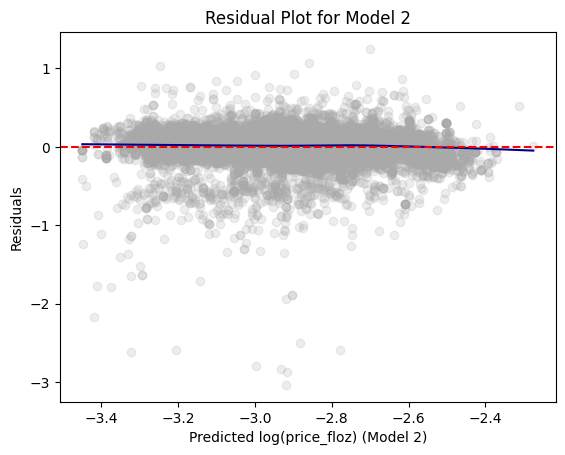

In [ ]:
res_2 = dtest2.select(["prediction", "log_price_floz"]).toPandas()
res_2['residual'] = res_2['log_price_floz'] - res_2['prediction']



plt.scatter(res_2["prediction"], res_2["residual"], alpha=0.2, color="darkgray")

smoothed = sm.nonparametric.lowess(res_2["residual"], res_2["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

plt.axhline(y=0, color="red", linestyle="--")

plt.xlabel("Predicted log(price_floz) (Model 2)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model 2")
plt.show()


### Model 3

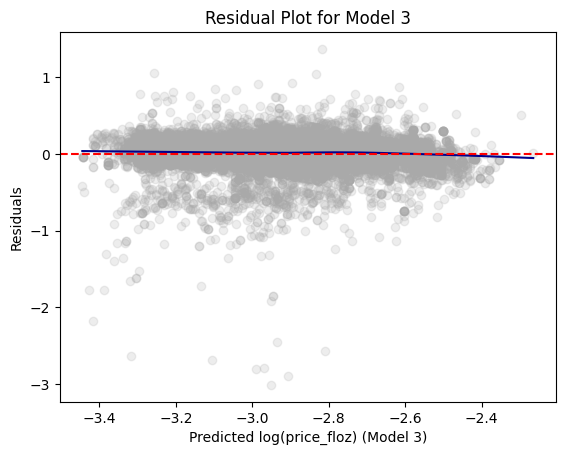

In [ ]:
res_3 = dtest3.select(["prediction", "log_price_floz"]).toPandas()
res_3['residual'] = res_3['log_price_floz'] - res_3['prediction']



plt.scatter(res_3["prediction"], res_3["residual"], alpha=0.2, color="darkgray")

smoothed = sm.nonparametric.lowess(res_3["residual"], res_3["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

plt.axhline(y=0, color="red", linestyle="--")

plt.xlabel("Predicted log(price_floz) (Model 3)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model 3")
plt.show()


- On average, the predictions tend to be relatively close to actual, shown by the points sticking relatively close to the horizontal 0 line.

## Q8

> **Model Choice**:
- I would most likely choose model 3, as it has the higest R2, and performs seemingly as well as the others on the unseen test set.